In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm 
from nltk.corpus import stopwords

RAW DATA LOADING.

In [ ]:
# Input data files are available in the "../input/" directory.
train = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")

In [ ]:
# Converting data in Data framres 
train=pd.DataFrame(train)
test=pd.DataFrame(test)

Check for Null Values for train

In [ ]:
print("Train NULL ",train.isnull().sum())
print("Test NULL",test.isnull().sum())

It is seen clear that non-essential columns have higher null values.

<h3> A good idea to count the amount of missing values before diving into any analysis.</h1>
<h3> Lets also see how many missing values (in percentage) we are dealing with. </h1>


In [ ]:
miss_val_train_df = train.isnull().sum(axis=0) / len(train)
miss_val_train_df = miss_val_train_df[miss_val_train_df > 0] * 100
miss_val_train_df

**Demographics** : Statistical data relating to the population and particular groups within it

In [ ]:
#Source:simple-eda-text-preprocessing-jigsaw
import matplotlib.pyplot as plt
import seaborn as sns
demographics = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()
del sns,weighted_toxic,demographics,ax

<h3>Toxic vs Non-Toxic

In [ ]:
# lets create a list of all the identities tagged in this dataset. This list given in the data section of this competition. 
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

In [ ]:
# getting the dataframe with identities tagged
train_labeled_df = train.loc[:, ['target'] + identities ].dropna()
# lets define toxicity as a comment with a score being equal or .5
# in that case we divide it into two dataframe so we can count toxic vs non toxic comment per identity
toxic_df = train_labeled_df[train_labeled_df['target'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['target'] < .5][identities]

In [ ]:
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.where(train_labeled_df == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(train_labeled_df == 0, other = 1).sum()

In [ ]:
# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

Correlation b/w data

In [30]:
with_date_df = train.loc[:, ['created_date', 'target'] + identities].dropna()
comments_with_date_df = train.loc[:, ['created_date', 'target','comment_text'] + identities].dropna()
comments_with_date_df['created_date'] = pd.to_datetime(with_date_df['created_date'].apply(lambda dt: dt[:10]))
comments_with_date_df['comment_count'] = 1

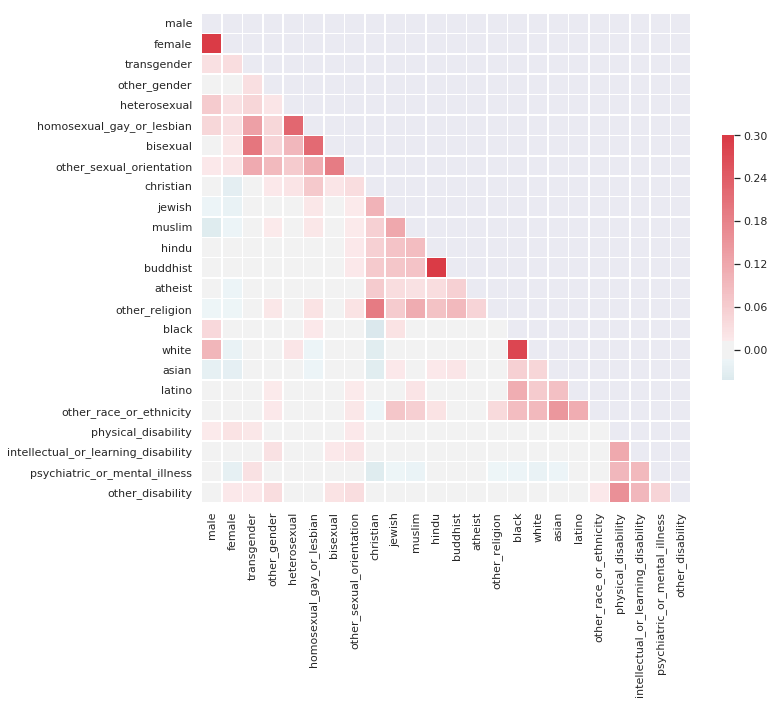

In [31]:
# Lets import seaborn
import seaborn as sns
# Compute the correlation matrix
corr = comments_with_date_df[identities].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The heatmap plot of the correlation between the identities is very insightful. I will summarize my observations below. As always, if you see something interesting please mention it to me in the comment section.
It is interesting to see that strong correlations form triangular area at the edge of diagonal.
This basically means that there is a strong correlation between the groups of the identity (gender, religion, races, disabilities). This means, the comments where male identity is the target, female identity is also very likely to be the target.
In another words, in toxic and non-toxic comments, people tend to make it about one group vs another quiet frequently.

PREPROCESS FILTERS.

Contractions Which includes abrevations and slangs.

In [ ]:
contract={'albertans':'inhabitant of the Canadian province of Alberta','SB91': 'establishes a pretrial services program at the department of corrections to conduct pretrial risk assessments using an objective data based validated pretrial risk assessment tool', 'tRump': 'trump', 'utmterm': 'utm term', 'FakeNews': 'fake news', 'Gʀᴇat': 'great', 'ʙᴏᴛtoᴍ': 'bottom', 'washingtontimes': 'washington times', 'garycrum': 'gary crum', 'htmlutmterm': 'html utm term', 'RangerMC': 'car', 'TFWs': 'tuition fee waiver scheme', 'SJWs': 'sjw', 'Koncerned': 'concerned', 'Vinis': 'vinys', 'Yᴏᴜ': 'you', 'Trumpsters': 'avid supporter and follower of donald trump', 'Trumpian': 'resembling or pertaining to the philosophy rhetoric and style of donald trump', 'bigly': 'big league', 'Trumpism': 'the political positions of usa president donald trump', 'Yoyou': 'you', 'Auwe': 'exclamation of wonder', 'Drumpf': 'trump', 'Brexit': 'british exit', 'utilitas': 'academic journal covering political philosophy and jurisprudence', 'ᴀ': 'a', '😉': 'wink', '😂': 'joy', '😀': 'context of laughing, rejoicing, and being excited at something like the upcoming holiday', 'theguardian': 'the guardian', 'deplorables': 'half of the supporters of trump', 'theglobeandmail': 'the global and mail', 'justiciaries': 'justiciary', 'creditdation': 'Accreditation', 'doctrne': 'doctrine', 'fentayal': 'fentanyl', 'designation-': 'designation', 'CONartist': 'con-artist', 'Mutilitated': 'Mutilated', 'Obumblers': 'bumblers', 'negotiatiations': 'negotiations', 'dood-': 'dood', 'irakis': 'iraki', 'cooerate': 'cooperate', 'COx': 'cox', 'racistcomments': 'racist comments', 'envirnmetalists': 'environmentalists', "Trump's": 'trump is', "'cause": 'because', ',cause': 'because', ';cause': 'because', 'ain"t': 'am not', 'ain,t': 'am not', 'ain;t': 'am not', 'ain´t': 'am not', 'ain’t': 'am not', "aren't": 'are not', 'aren,t': 'are not', 'aren;t': 'are not', 'aren´t': 'are not', 'aren’t': 'are not', "can't": 'cannot', "can't've": 'cannot have', 'can,t': 'cannot', 'can,t,ve': 'cannot have', 'can;t': 'cannot', 'can;t;ve': 'cannot have', 'can´t': 'cannot', 'can´t´ve': 'cannot have', 'can’t': 'cannot', 'can’t’ve': 'cannot have', "could've": 'could have', 'could,ve': 'could have', 'could;ve': 'could have', "couldn't": 'could not', "couldn't've": 'could not have', 'couldn,t': 'could not', 'couldn,t,ve': 'could not have', 'couldn;t': 'could not', 'couldn;t;ve': 'could not have', 'couldn´t': 'could not', 'couldn´t´ve': 'could not have', 'couldn’t': 'could not', 'couldn’t’ve': 'could not have', 'could´ve': 'could have', 'could’ve': 'could have', "didn't": 'did not', 'didn,t': 'did not', 'didn;t': 'did not', 'didn´t': 'did not', 'didn’t': 'did not', "doesn't": 'does not', 'doesn,t': 'does not', 'doesn;t': 'does not', 'doesn´t': 'does not', 'doesn’t': 'does not', "don't": 'do not', 'don,t': 'do not', 'don;t': 'do not', 'don´t': 'do not', 'don’t': 'do not', "hadn't": 'had not', "hadn't've": 'had not have', 'hadn,t': 'had not', 'hadn,t,ve': 'had not have', 'hadn;t': 'had not', 'hadn;t;ve': 'had not have', 'hadn´t': 'had not', 'hadn´t´ve': 'had not have', 'hadn’t': 'had not', 'hadn’t’ve': 'had not have', "hasn't": 'has not', 'hasn,t': 'has not', 'hasn;t': 'has not', 'hasn´t': 'has not', 'hasn’t': 'has not', "haven't": 'have not', 'haven,t': 'have not', 'haven;t': 'have not', 'haven´t': 'have not', 'haven’t': 'have not', "he'd": 'he would', "he'd've": 'he would have', "he'll": 'he will', "he's": 'he is', 'he,d': 'he would', 'he,d,ve': 'he would have', 'he,ll': 'he will', 'he,s': 'he is', 'he;d': 'he would', 'he;d;ve': 'he would have', 'he;ll': 'he will', 'he;s': 'he is', 'he´d': 'he would', 'he´d´ve': 'he would have', 'he´ll': 'he will', 'he´s': 'he is', 'he’d': 'he would', 'he’d’ve': 'he would have', 'he’ll': 'he will', 'he’s': 'he is', "how'd": 'how did', "how'll": 'how will', "how's": 'how is', 'how,d': 'how did', 'how,ll': 'how will', 'how,s': 'how is', 'how;d': 'how did', 'how;ll': 'how will', 'how;s': 'how is', 'how´d': 'how did', 'how´ll': 'how will', 'how´s': 'how is', 'how’d': 'how did', 'how’ll': 'how will', 'how’s': 'how is', "i'd": 'i would', "i'll": 'i will', "i'm": 'i am', "i've": 'i have', 'i,d': 'i would', 'i,ll': 'i will', 'i,m': 'i am', 'i,ve': 'i have', 'i;d': 'i would', 'i;ll': 'i will', 'i;m': 'i am', 'i;ve': 'i have', "isn't": 'is not', 'isn,t': 'is not', 'isn;t': 'is not', 'isn´t': 'is not', 'isn’t': 'is not', "it'd": 'it would', "it'll": 'it will', "It's": 'it is', "it's": 'it is', 'it,d': 'it would', 'it,ll': 'it will', 'it,s': 'it is', 'it;d': 'it would', 'it;ll': 'it will', 'it;s': 'it is', 'it´d': 'it would', 'it´ll': 'it will', 'it´s': 'it is', 'it’d': 'it would', 'it’ll': 'it will', 'it’s': 'it is', 'tRump:trumpi´d': 'i would', 'i´ll': 'i will', 'i´m': 'i am', 'i´ve': 'i have', 'i’d': 'i would', 'i’ll': 'i will', 'i’m': 'i am', 'i’ve': 'i have', "let's": 'let us', 'let,s': 'let us', 'let;s': 'let us', 'let´s': 'let us', 'let’s': 'let us', "ma'am": 'madam', 'ma,am': 'madam', 'ma;am': 'madam', "mayn't": 'may not', 'mayn,t': 'may not', 'mayn;t': 'may not', 'mayn´t': 'may not', 'mayn’t': 'may not', 'ma´am': 'madam', 'ma’am': 'madam', "might've": 'might have', 'might,ve': 'might have', 'might;ve': 'might have', "mightn't": 'might not', 'mightn,t': 'might not', 'mightn;t': 'might not', 'mightn´t': 'might not', 'mightn’t': 'might not', 'might´ve': 'might have', 'might’ve': 'might have', "must've": 'must have', 'must,ve': 'must have', 'must;ve': 'must have', "mustn't": 'must not', 'mustn,t': 'must not', 'mustn;t': 'must not', 'mustn´t': 'must not', 'mustn’t': 'must not', 'must´ve': 'must have', 'must’ve': 'must have', "needn't": 'need not', 'needn,t': 'need not', 'needn;t': 'need not', 'needn´t': 'need not', 'needn’t': 'need not', "oughtn't": 'ought not', 'oughtn,t': 'ought not', 'oughtn;t': 'ought not', 'oughtn´t': 'ought not', 'oughtn’t': 'ought not', "sha'n't": 'shall not', 'sha,n,t': 'shall not', 'sha;n;t': 'shall not', "shan't": 'shall not', 'shan,t': 'shall not', 'shan;t': 'shall not','theglobeandmail':'newspaper','chaput':'american prelate','manafort':'American lobbyist, political consultant, former lawyer, and convicted felon', 'shan’t': 'shall not', 'sha´n´t': 'shall not', 'sha’n’t': 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', 'she,d': 'she would', 'she,ll': 'she will', 'she,s': 'she is', 'she;d': 'she would', 'she;ll': 'she will', 'she;s': 'she is', 'she´d': 'she would', 'she´ll': 'she will', 'she´s': 'she is', 'she’d': 'she would', 'she’ll': 'she will', 'she’s': 'she is', "should've": 'should have', 'should,ve': 'should have', 'should;ve': 'should have', "shouldn't": 'should not', 'shouldn,t': 'should not', 'shouldn;t': 'should not', 'shouldn´t': 'should not', 'shouldn’t': 'should not', 'should´ve': 'should have', 'should’ve': 'should have', "that'd": 'that would', "that's": 'that is', 'that,d': 'that would', 'that,s': 'that is', 'that;d': 'that would', 'that;s': 'that is', 'that´d': 'that would', 'that´s': 'that is', 'that’d': 'that would', 'that’s': 'that is', "there'd": 'there had', "there's": 'there is', 'there,d': 'there had', 'there,s': 'there is', 'there;d': 'there had', 'there;s': 'there is', 'there´d': 'there had', 'there´s': 'there is', 'there’d': 'there had', 'there’s': 'there is', "they'd": 'they would', "they'll": 'they will', "they're": 'they are', "they've": 'they have', 'they,d': 'they would', 'they,ll': 'they will', 'they,re': 'they are', 'they,ve': 'they have', 'they;d': 'they would', 'they;ll': 'they will', 'they;re': 'they are', 'they;ve': 'they have', 'they´d': 'they would', 'they´ll': 'they will', 'they´re': 'they are', 'they´ve': 'they have', 'they’d': 'they would', 'they’ll': 'they will', 'they’re': 'they are', 'they’ve': 'they have', "wasn't": 'was not', 'wasn,t': 'was not', 'wasn;t': 'was not', 'wasn´t': 'was not', 'wasn’t': 'was not', "we'd": 'we would', "we'll": 'we will', "we're": 'we are', "we've": 'we have', 'we,d': 'we would', 'we,ll': 'we will', 'we,re': 'we are', 'we,ve': 'we have', 'we;d': 'we would', 'we;ll': 'we will', 'we;re': 'we are', 'we;ve': 'we have', "weren't": 'were not', 'weren,t': 'were not', 'weren;t': 'were not', 'weren´t': 'were not', 'weren’t': 'were not', 'we´d': 'we would', 'we´ll': 'we will', 'we´re': 'we are', 'we´ve': 'we have', 'we’d': 'we would', 'we’ll': 'we will', 'we’re': 'we are', 'we’ve': 'we have', "what'll": 'what will', "what're": 'what are', "what's": 'what is', "what've": 'what have', 'what,ll': 'what will', 'what,re': 'what are', 'what,s': 'what is', 'what,ve': 'what have', 'what;ll': 'what will', 'what;re': 'what are', 'what;s': 'what is', 'what;ve': 'what have', 'what´ll': 'what will', 'what´re': 'what are', 'what´s': 'what is', 'what´ve': 'what have', 'what’ll': 'what will', 'what’re': 'what are', 'what’s': 'what is', 'what’ve': 'what have', "where'd": 'where did', "where's": 'where is', 'where,d': 'where did', 'where,s': 'where is', 'where;d': 'where did', 'where;s': 'where is', 'where´d': 'where did', 'where´s': 'where is', 'where’d': 'where did', 'where’s': 'where is', "who'll": 'who will', "who's": 'who is', 'who,ll': 'who will', 'who,s': 'who is', 'who;ll': 'who will', 'who;s': 'who is', 'who´ll': 'who will', 'who´s': 'who is', 'who’ll': 'who will', 'who’s': 'who is', "won't": 'will not', 'won,t': 'will not', 'won;t': 'will not', 'won´t': 'will not', 'won’t': 'will not', "wouldn't": 'would not', 'wouldn,t': 'would not', 'wouldn;t': 'would not', 'wouldn´t': 'would not', 'wouldn’t': 'would not', "you'd": 'you would', "you'll": 'you will', "you're": 'you are', 'you,d': 'you would', 'you,ll': 'you will', 'you,re': 'you are', 'you;d': 'you would', 'you;ll': 'you will', 'you;re': 'you are', 'you´d': 'you would', 'you´ll': 'you will', 'you´re': 'you are', 'you’d': 'you would', 'you’ll': 'you will', 'you’re': 'you are', '´cause': 'because', '’cause': 'because', "you've": 'you have', "could'nt": 'could not', "havn't": 'have not', 'here’s': 'here is', 'i""m': 'i am', "i'am": 'i am', "i'l": 'i will', "i'v": 'i have',
         }


In [ ]:
contract1={"wan't": 'want', "was'nt": 'was not', "who'd": 'who would', "who're": 'who are', "who've": 'who have', "why'd": 'why would','khadr':'Omar khadr pleaded guilty to the murder of U.S. Army Sergeant 1st Class Christopher Speer and other charges',
"would've": 'would have', "y'all": 'you all', "y'know": 'you know', 'you.i': 'you i', "your'e": 'you are', "arn't": 'are not', "agains't": 'against', "c'mon": 'common', "doens't": 'does not', 'don""t': 'do not', "dosen't": 'does not', "dosn't": 'does not', "shoudn't": 'should not', "that'll": 'that will', "there'll": 'there will', "there're": 'there are', "this'll": 'this all', "u're": 'you are', "ya'll": 'you all', "you'r": 'you are', 'you’ve': 'you have', "d'int": 'did not', "did'nt": 'did not', "din't": 'did not', "dont't": 'do not', "gov't": 'government', "i'ma": 'i am', "is'nt": 'is not', '‘I': 'I', 'ᴀɴᴅ': 'and', 'ᴛʜᴇ': 'the', 'ʜᴏᴍᴇ': 'home', 'ᴜᴘ': 'up', 'ʙʏ': 'by', 'ᴀᴛ': 'at', '…and': 'and', 'civilbeat': 'practices watchdog journalism', 'TrumpCare': 'American Health Care Act of 2017', 'Trumpcare': 'trump care', 'OBAMAcare': 'patient protection and affordable care act ', 'ᴄʜᴇᴄᴋ': 'check', 'ғᴏʀ': 'for', 'ᴛʜɪs': 'this', 'ᴄᴏᴍᴘᴜᴛᴇʀ': 'computer', 'ᴍᴏɴᴛʜ': 'month', 'ᴡᴏʀᴋɪɴɢ': 'working', 'ᴊᴏʙ': 'job', 'ғʀᴏᴍ': 'from', 'Sᴛᴀʀᴛ': 'start', 'gubmit': 'submit', 'CO₂': 'carbondioxide', 'ғɪʀsᴛ': 'first', 'ᴇɴᴅ': 'end', 'ᴄᴀɴ': 'can', 'ʜᴀᴠᴇ': 'have', 'ᴛᴏ': 'to', 'ʟɪɴᴋ': 'link', 'ᴏғ': 'of', 'ʜᴏᴜʀʟʏ': 'hourly', 'ᴡᴇᴇᴋ': 'week', 'ᴇxᴛʀᴀ': 'extra', 'Gʀᴇᴀᴛ': 'great', 'sᴛᴜᴅᴇɴᴛs': 'student', 'thÈ': 'the', 'thiŚ': 'this', 'needtoimpeach': 'house of representatives, democrats can initiate impeachment proceedings against Donald Trump', 'whitefragilitycankissmyass': 'white fragility can kiss my ass', 'altrightpubs': 'loosely connected far right white nationalist movement', 'sᴛᴀʏ': 'stay', 'ᴍᴏᴍs': 'mother', 'ᴏʀ': 'or', 'ᴀɴʏᴏɴᴇ': 'anyone', 'ɴᴇᴇᴅɪɴɢ': 'needing', 'ᴀɴ': 'an', 'ɪɴᴄᴏᴍᴇ': 'income', 'ʀᴇʟɪᴀʙʟᴇ': 'reliable', 'ᴄan': 'can', 'Zuptas': 'american gupta family', 'ʏᴏᴜʀ': 'your', 'sɪɢɴɪɴɢ': 'signing', 'ʙᴏᴛᴛᴏᴍ': 'bottom', 'ғᴏʟʟᴏᴡɪɴɢ': 'following', 'Mᴀᴋᴇ': 'make', 'ᴄᴏɴɴᴇᴄᴛɪᴏɴ': 'connection', 'broadwayinsurance': 'insurance company', 'Papadopoulus': 'former member of the foreign policy advisory panel to Donald Trump', 'AgriSA': 'agriculture company', 'Nevillea': 'group of plants ', 'DTJR': 'donald trump', 'SSRAA': 'Southern Southeast Regional Aquaculture Association', 'Osweiller': 'american football quarterback who is currently a free agent', 'cruxnow': 'online newspaper that focuses on news related to the Catholic Church', 'LotL': 'magazine published in australia', 'Turdeau': 'shit poop excrement', 'Victimitis': 'silent killer moving so stealthily that sufferers do not recognize its symptoms', '😁': 'beaming face with smiling eyes', 'ɪɴᴛᴇʀɴᴇᴛ': 'internet', 'financialpost': 'newspaper', 'ʜaᴠᴇ': ' have ', 'ᴄaɴ': ' can ', 'Maᴋᴇ': ' make ', 'ʀᴇʟɪaʙʟᴇ': ' reliable ', 'ɴᴇᴇᴅ': ' need ', 'ᴏɴʟʏ': ' only ', 'Sayfullo': 'terror suspect', 'Bumpski': 'gun', 'SLOTER': 'american football quarterback ', 'Vectum': 'between the vagina and the anus', 'etroit': 'narrow', 'u5a1a1': ' human mitochondrial dna haplogroup', 'ANN7': 'news channel', 'Chinp': 'chimpanzee', 'Khadrs': 'detained by bay for ten years, during which he pleaded guilty to the murder', 'Hanomansing': 'canadian television journalist', 'fRANCIS': 'sacred pope francis', 'TIFTFY': 'there i fixed that for you', 'WTFMSM': 'what the fuck main stream media', 'Timol': 'drug used to treat hypertension acute myocardial infarction migraine prophylaxis', 'SISs': 'make a hissing sound', 'nadcp': 'national association of drug court professionals', 'Chumpty': 'most often is short with blonde hair and is a bit of a numpty', 'Kahdr': 'detained by bay for ten years, during which he pleaded guilty to the murder', 'Gorkov': 'russian banker and attorney', 'DACAs': 'drug and alcohol clinical advisory service', 'onYouTube': ' on youtube', 'theDonald': 'president donald trump', 'Kizla': 'journalst', 'HitLIARy': 'hilaryclinton', 'onkey': 'Monkeys', 'Trumplethinskin': 'donald trump in a nutshell', 'thetyee': 'canadian news magazine ', 'AntiFa': 'a political protest movement comprising autonomous groups affiliated by their militant opposition to fascism and other forms of extreme right wing ideology', 'Birdich': 'american baseball executive', 'torontosun': 'tabloid', 'vancouversun': 'newspaper', 'consservativereviews': 'american news media company owned', 'muckamuck': 'a person of great importance or self importance', 'gubmut': 'person who can be classed as a total geek or nerd', 'whataboutism': 'attempts to discredit an opponent position by charging them with hypocrisy without directly refuting or disproving their argument', '😊': 'happiness and warm', 'Dotard': 'dotard', 'Ossoff': 'american politician', 'Moyane': 'commissioner of south african revenue service', 'djou': 'hawaii house of representatives and the honolulu city council', 'Pizzagate': 'debunked conspiracy theory', 'akleg': 'state legislature of the usa', 'Trumpettes': 'are a group of US socialites all women who have one mission in their sight to see donald trump reelected as usa president', 'khadr': 'detained by the united states at guantanamo Bay for ten years during which he pleaded guilty to the murder and other charges', 'commondreams': 'breaking news and views for the progressive community', 'Trumpland': 'documentary film usa presidential election campaign', 'talkingpointsmemo': ' political journalism website', 'TheDonald': 'president trump', 'ncronline': 'newspaper', 'scientificamerican': 'magazine', 'tRUMP': 'trump', '🙄': 'expressing disbelief annoyance impatience boredom and disdain', 'motelycrew ': 'roughly organized assembly of individuals of various backgrounds appearance and character', 'Nageak': 'American Politician', 'Zupta': 'wealthy indian-born South african family', 'Tridentinus': 'edible mushroom', 'dailycaller': 'american news and opinion website', 'Cheetolini': 'president trump', 'Trudeaus': 'prime minister of canada', 'Finicum': 'american spokesman', 'Trumpkins': 'carving donald trumps face onto a pumpkin', 'Donkel': 'dark', 'Daesh': 'terrorist organization', 'Trudope': 'corrupt prime minister of canada', 'shibai': 'state of hawaii', '2gTbpns': 'electronic cigarettes', 'klastri': 'cluster', 'ᴇxᴛʀa': ' extra ', 'aɴ': ' an ', 'aɴʏᴏɴᴇ': ' anyone ', 'Kurdistanis': 'kurdistan', 'sᴛaʏ': 'stay', 'Sᴛaʀᴛ': ' start', 'SHOPO': 'shop'} 

In [ ]:
Stopwords=['it', "it's", 'its', 'itself', 'themselves', 
           'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these','tillerson'
           'those','is','are','was','were','been','be', 'being', 'have', 'has',
           'had', 'having', 'do', 'does', 'did', 'doing','an', 'the',
           'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of','gorsuch'
           'at', 'by', 'for', 'with', 'about','notley',
           'between', 'into', 'through', 'during', 'before', 'after', 'above',
           'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'over', 'under',
           'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where',
           'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
           'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 
           'very', 's', 't', 'can',
           'will', 'just',"don't", 'should','have', 'now', 'd', 'll', 'm',
           'o', 're', 've', 'y', 'ain', 'aren', "arent", 'couldn', "couldnt",
           'didn', "didnt", 'doesn', "doesn", 'hadn', "hadnt", 'has','haven',
           "have", 'isn', "isnt", 'ma', 'mightn', "mightn't", 'mustn', "mustn't",
           'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
           "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'MAGAphant','PMPK','mcubz','Utqiagvik','Siemien','BLOTUS','JSB1','NFLGTV','Sniktaw','kiragirl','Tpubs','twittler','siemian','tJZ783','sloter','gubmit','guptas','getcivil','ZANC','KD48','mtf1953','NP5491','Covfefe','RAILFAIL','bsdetection','hapaguy','BCFN','Bavius','Larsy','jobpro22','xianleft','s1600','s2017','brad12','cn535aU5UsN7Lj8X8','HitLIARy','newsletterad','PETROWS','keaukaha','AKLNG','TransMountain'
          'ITMFA','jerry69','RadirD','McWynnety','Pandora17','Lazeelink','covfefe','BCLibs','Krookwell','Trumpty','Exedus',
          'LesterP','flexpipe','pgtype','907AK','diverdave','Outsider77','Nurnie','MAGAphants','Crapwell','Meggsy','11e6',
          '11e7','bavius','Ontariowe','Layla4','garycrum','Brexit','bigly','wiliki','Saullie','Koncerned','RangerMC'                       
          'ChickenLittle','Sambrailo','Binkleys','AtheO','JSwr','HIHS','brexit','sb21',
          '20JPI','2green','Naole','ScreenViewsHD','physicaled','I‎t',
          'Kanekuni','arfc','Kilber','NFLHQTV','Trustsy']

In [ ]:
def preprocess(data):
    '''
    Reference: https://www.kaggle.com/abhigupta4981/pytorch-train-with-callbacks
               and
               simple-eda-text-preprocessing-jigsaw
    '''
    print("pre-processing")
    punct = [',', '.', '"', ':', ')','ᴀ','(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^','\n'
          '®', '`', '<', '→','Vinis', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à','anᴅ', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
    
    def clean_special_chars(text, punct):
        def get_misspell(text):
            global contract
            global contract1
            global Stopwords
            for word in text.split():
                word_l=word.lower()
                if word_l in contract:
                    text = text.replace(word, contract[word_l])
                elif word in contract:
                    text = text.replace(word, contract[word])
                elif word_l in contract1:
                    text = text.replace(word,contract1[word_l])
                elif word in contract1:
                    text = text.replace(word,contract1[word])
                    
            return text
        text=get_misspell(text)    
        for p in (punct):
            text = text.replace(p,' ')
        return text
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))

    return data

FILTERING ENTIRE RAW TRAINING DATA.

In [ ]:
# Pre-proccesing train data
data=preprocess(train['comment_text'].astype(str))
test_data=preprocess(test['comment_text'].astype(str))

TOKENIZE AND LET THE WHOLE DATA FIT FOR UNIQUE TOKENS.
- Optional: Pickling of files to save on temporary stages and Let some space created.

Checking vocab coverage and trying to reach 100%.

Removing Stop words.

In [ ]:
data[1]

In [ ]:

vocab={}
for comment in tqdm(data):                                     # For each comment
    sent=[]
    comment=comment.lower()
    for word in comment.split():                               # For each word
        if word in Stopwords:                                  # If version of word in Stopwords than delete
            comment=comment.replace(word,'')  
        elif word in vocab:                                    # If word not in stop words than add to vocab as it is not deleted
            vocab[word]=vocab[word]+1
            sent.append(word)
        else:
            vocab[word]=1
            sent.append(word)
    comment=" ".join(sent)
print("Training Data Prepared")

for comment1 in tqdm(test_data):
    sent=[]
    comment1.lower()
    for word in comment1.split():
        word_l=word.lower()
        if word_l in Stopwords:                                # If lower version of word in Stopwords than delete
            comment=comment.replace(word_l,'')
        elif word in Stopwords:                                # If word in Stopwords than delete
            comment=comment.replace(word,'')
        
        elif word in vocab:                                    # If word not in stop words than add to vocab as it is not deleted
            vocab[word]=vocab[word]+1
            sent.append(word)
        else:
            vocab[word]=1
            sent.append(word)
    comment1=" ".join(sent)
print("Testing Data Prepared")
print("Total Vocab %d"%len(vocab))
del comment,comment1,Stopwords,sent

* Loading Glove Embeddings. 
* 840B embeddings, each corresponds to 300 dimensions.

In [ ]:
data[1]

In [ ]:
f = open("../input/glove840b300dtxt/glove.840B.300d.txt",'r') # Load Model
embedding_values = {}
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_values[word]=coef
print("Model Loaded",len(embedding_values))

Checking the Vocab coverage

In [ ]:
left_vocab={}
for j in vocab.keys():
    if j not in embedding_values:
        left_vocab[vocab[j]]=j
z=float((len(vocab)-len(left_vocab))*100/len(vocab))
print(f"Total Coverage %.2f "%z + '%')

Remaining Contraction or Stopwords that need to be resolved.

But we can skip them as most of them are names of people and places. 

In [ ]:
for j in sorted(left_vocab.keys(),reverse=True):
        print(left_vocab[j]+":"+str(j))

In [ ]:
# Tokenize_lammatize and Stop Words removal
from keras.preprocessing.text import Tokenizer
Token=Tokenizer()
Total=data
Total.append(test_data) #Total Data available for Vocab
Token.fit_on_texts(Total)
sequence = Token.texts_to_sequences(data)
vocab_size = len(sequence)+1

In [ ]:
print(dir())

In [ ]:
del toxic_vs_non_toxic,toxic_df,toxic_count,vocab,word,word_l,preprocess,identities,j,line,left_vocab,contract,contract1,WordNetLemmatizer

In [ ]:
vocab_size

In [ ]:
"""https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution"""
identity_columns = ['asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender',
       'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']
# Overall
weights = np.ones((len(train),)) / 4

# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4

# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4

# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(np.int) + (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4

loss_weight = 1.0 / weights.mean()

y_train = np.vstack((train['target'],weights)).T

del train,test,data,test_data

To Check All Loaded files and imports in RAM.

In [ ]:
# Check All Loaded files and imports in RAM
print(dir())
del Total
import gc

In [ ]:
#Loading Keras for training 
from keras.models import Sequential
from keras.layers import Dense,Embedding,CuDNNLSTM
from keras.layers import Convolution1D, GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.layers import Bidirectional
from keras.preprocessing.sequence import pad_sequences
gc.collect()

In [ ]:


embedding_matrix = np.zeros((1804875,300))
# Padding Sequence Which are nothing just integer value Encoded sentences
pad_seq = pad_sequences(sequence,maxlen = 100)

# Preparing Matrix for word Embeddings out of Vocab used
for word,i in tqdm(Token.word_index.items()):
    values = embedding_values.get(word)
    if values is not None:
        embedding_matrix[i] = values
del embedding_values,f

Bi directional LSTM used in model. Total trainable Features: 187,586

In [ ]:
print(dir())

In [ ]:
del stopwords,threading,identity_columns,loss_weight,miss_val_train_df,non_toxic_count,non_toxic_df,np

In [ ]:
# Sentence Via Biderectional LSTM
model=Sequential()
model.add(Embedding(1804875,300,input_length = 300,weights = [embedding_matrix],trainable = False))
model.add(Bidirectional(CuDNNLSTM(300,return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(300,return_sequences=True)))
model.add(GlobalAveragePooling1D())
model.add(Dense(900,activation = 'relu'))
model.add(Dense(400, activation = 'sigmoid'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()


    Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(pad_seq,y_train, test_size=0.3, random_state=42)

Train Model

In [ ]:
history=model.fit(X_train,y_train,epochs=5,batch_size=100,validation_data=(X_test,y_test))

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**According to results 5 Epochs suits best **

In [ ]:
del pad_seq,X_train, X_test, y_train, y_test
sequence = Token.texts_to_sequences(test_data)
test_pad = pad_sequences(sequence,maxlen = 100)
prediction = model.predict(test_pad)
del test_data,Total,Token,embedding_matrix,embedding_values

In [ ]:
#Alining the values to submit
#Submiting the results
submission = pd.DataFrame([test['id']]).T
submission['prediction'] = [float(x) for x,_ in prediction]

In [ ]:
submission.to_csv('submission.csv', index=False)
submission.head()